# GraphToolbox - Load Example

This notebook was succesfully tested with Python 3.11.9.

## Importing libraries

Importing all libraries should take a minute or two.

In [1]:
# General libraries
import gc
import torch
from torch_geometric.nn.conv import *
from torch_geometric.nn.models import *
from torch_geometric import seed_everything

# GraphToolbox
from graphtoolbox.data.dataset import *
from graphtoolbox.models.gnn import *
from graphtoolbox.optim.optimizer import *
from graphtoolbox.training.trainer import Trainer
from graphtoolbox.utils.attention import *
from graphtoolbox.utils.helper_functions import *
from graphtoolbox.utils.visualizations import *

# Autoreload
%load_ext autoreload
%autoreload 2


/home/a89182/miniconda311/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /fscronos/home/a89182/miniconda311/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/a89182/miniconda311/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /fscronos/home/a89182/miniconda311/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## CUDA or not CUDA ?

In [2]:
print('CUDA'*(torch.cuda.is_available())+(1-torch.cuda.is_available())*'not CUDA')

CUDA


## Instantiating graph objects

There are two graph objects in the following cell:

- a **DataClass** object, which is always defined by three arguments: `path_train` which is the path to the training dataset, `path_test` which is the path to the testing dataset, and `folder_config` which is the folder of your config file. There are additional keyword arguments if you want to specify a validation set. A DataClass object allows to manipulate the dataframes easily.

- a **GraphDataset** object, which is always defined by two arguments: `data` which is an instance of DataClass, `period` which specifies if it is a train., val. or test. dataset. If the dataset is for validation or test, then you will need to specify scalers: `scalers_feat` to scale the features, and `scalers_target` to scale the target. There are additional keyword arguments that you can find in the documentation. A GraphDataset object allows to manipulate the data as graph objects in the PyG format.

In [3]:
data_kwargs = {
    'node_var': 'Region',
    'features_to_lag': {'load': (1, 48), 'temp': (-47, -1)},
    'dummies': ['Instant', 'RegionInt', 'JourSemaine', 'DayType', 'offset'],
    'day_inf_train': '2015-01-01',
    'day_sup_train': '2018-01-01',
    'day_inf_val': '2018-01-01',
    'day_sup_val': '2018-12-31',
    'day_inf_test': '2019-01-01',
    'day_sup_test': '2019-12-31'
}

dataset_kwargs = {
    'batch_size': 32,
    'adj_matrix': 'dtw',
    'features_base': ['temp', 'nebu', 'wind', 'tempMax', 'tempMin', 'Posan', 'Instant', 'RegionInt', 'JourSemaine', 'JourFerie', 'offset', 'DayType', 'Weekend', 'temp_liss_fort', 'temp_liss_faible'] + [f'load_l{t}' for t in range(1, 48+1)] + [f'temp_l{t}' for t in range(-47, -1+1)],
    'target_base': 'load',
}

out_channels = 48
data = DataClass(path_train='./train.csv', 
                 path_test='./test.csv', 
                 data_kwargs=data_kwargs,
                 folder_config='.')

graph_dataset_train = GraphDataset(data=data, period='train', 
                                    graph_folder='../graph_representations',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=out_channels)
graph_dataset_val = GraphDataset(data=data, period='val', 
                                    scalers_feat=graph_dataset_train.scalers_feat, 
                                    scalers_target=graph_dataset_train.scalers_target,
                                    graph_folder='../graph_representations',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=out_channels)
graph_dataset_test = GraphDataset(data=data, period='test',
                                     scalers_feat=graph_dataset_train.scalers_feat, 
                                     scalers_target=graph_dataset_train.scalers_target,
                                     graph_folder='../graph_representations',
                                     dataset_kwargs=dataset_kwargs,
                                    out_channels=out_channels)

In [4]:
graph_dataset_test[0]

Data(x=[12, 183], edge_index=[2, 142], y=[12, 48], y_scaled=[12, 48], edge_weight=[142], mask_X=[12, 183], mask_y=[12, 48])

## Training a graph model

To train your graph models, the GraphToolbox has a training module. To use it, you need to instantiate a `Trainer` object which takes four arguments: `model` which is a graph model, and three GraphDataset objects `dataset_train`, `dataset_val` and `dataset_test`. There are other keyword arguments that you can find in the documentation. Then, when your trainer is instantiated, you can use the `train()` method. Note that if there is a pre-trained model with the same parameters, the trainer will automatically load the pre-trained weights (if you want to train another model with the same parameters, you will need to enforce `force_training=True` in the `train()` method).

Training model...


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


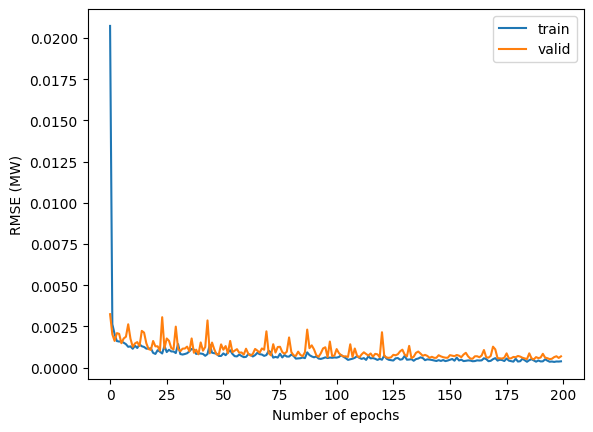

MAPE on test set: 1.9751 %
RMSE on test set: 1295.7280 MW


In [5]:
gc.collect()
torch.cuda.empty_cache()
seed_everything(seed=42)

# conv_class = GATv2Conv
# conv_kwargs = {'heads': 2}
# params = {'num_layers': 2, 'hidden_channels': 359, 'lr': 4e-4, 'batch_size': 32, 'adj_matrix': 'space', 'lam_reg': 0}

conv_class = GATConv
conv_kwargs = {'heads': 2}
params = {'num_layers': 3, 'hidden_channels': 364, 'lr': 1e-3, 'batch_size': 16, 'adj_matrix': 'gl3sr', 'lam_reg': 0}

# conv_class = ChebConv
# conv_kwargs = {'K': 3}
# params = {'num_layers': 1, 'hidden_channels': 249, 'lr': 6e-4, 'batch_size': 16, 'adj_matrix': 'distsplines', 'lam_reg': 0}

# conv_class = APPNP
# conv_kwargs = {'K': 1, 'alpha': .94}
# params = {'num_layers': 1, 'hidden_channels': 106, 'lr': 2e-3, 'batch_size': 16, 'adj_matrix': 'space'}

graph_dataset_train._set_adj_matrix(adj_matrix=params['adj_matrix'])
graph_dataset_val._set_adj_matrix(adj_matrix=params['adj_matrix'])
graph_dataset_test._set_adj_matrix(adj_matrix=params['adj_matrix'])

model = myGNN(
    in_channels=graph_dataset_train.num_node_features,
    num_layers=params["num_layers"],
    hidden_channels=params["hidden_channels"],
    out_channels=out_channels,
    conv_class=conv_class,
    conv_kwargs=conv_kwargs
)
trainer = Trainer(
    model=model,
    dataset_train=graph_dataset_train,
    dataset_val=graph_dataset_val,
    dataset_test=graph_dataset_test,
    batch_size=params["batch_size"],
    return_attention=False,
    model_kwargs={'lr': params["lr"], 'num_epochs': 200},
    lam_reg=0
)

pred_model_test, target_test, edge_index, attention_weights = trainer.train(
    plot_loss=True,
    force_training=True,
    save=True,
    patience=75
)
trainer.evaluate()

To visualize your predictions for each node, you can use the `plot_nodes()` method.

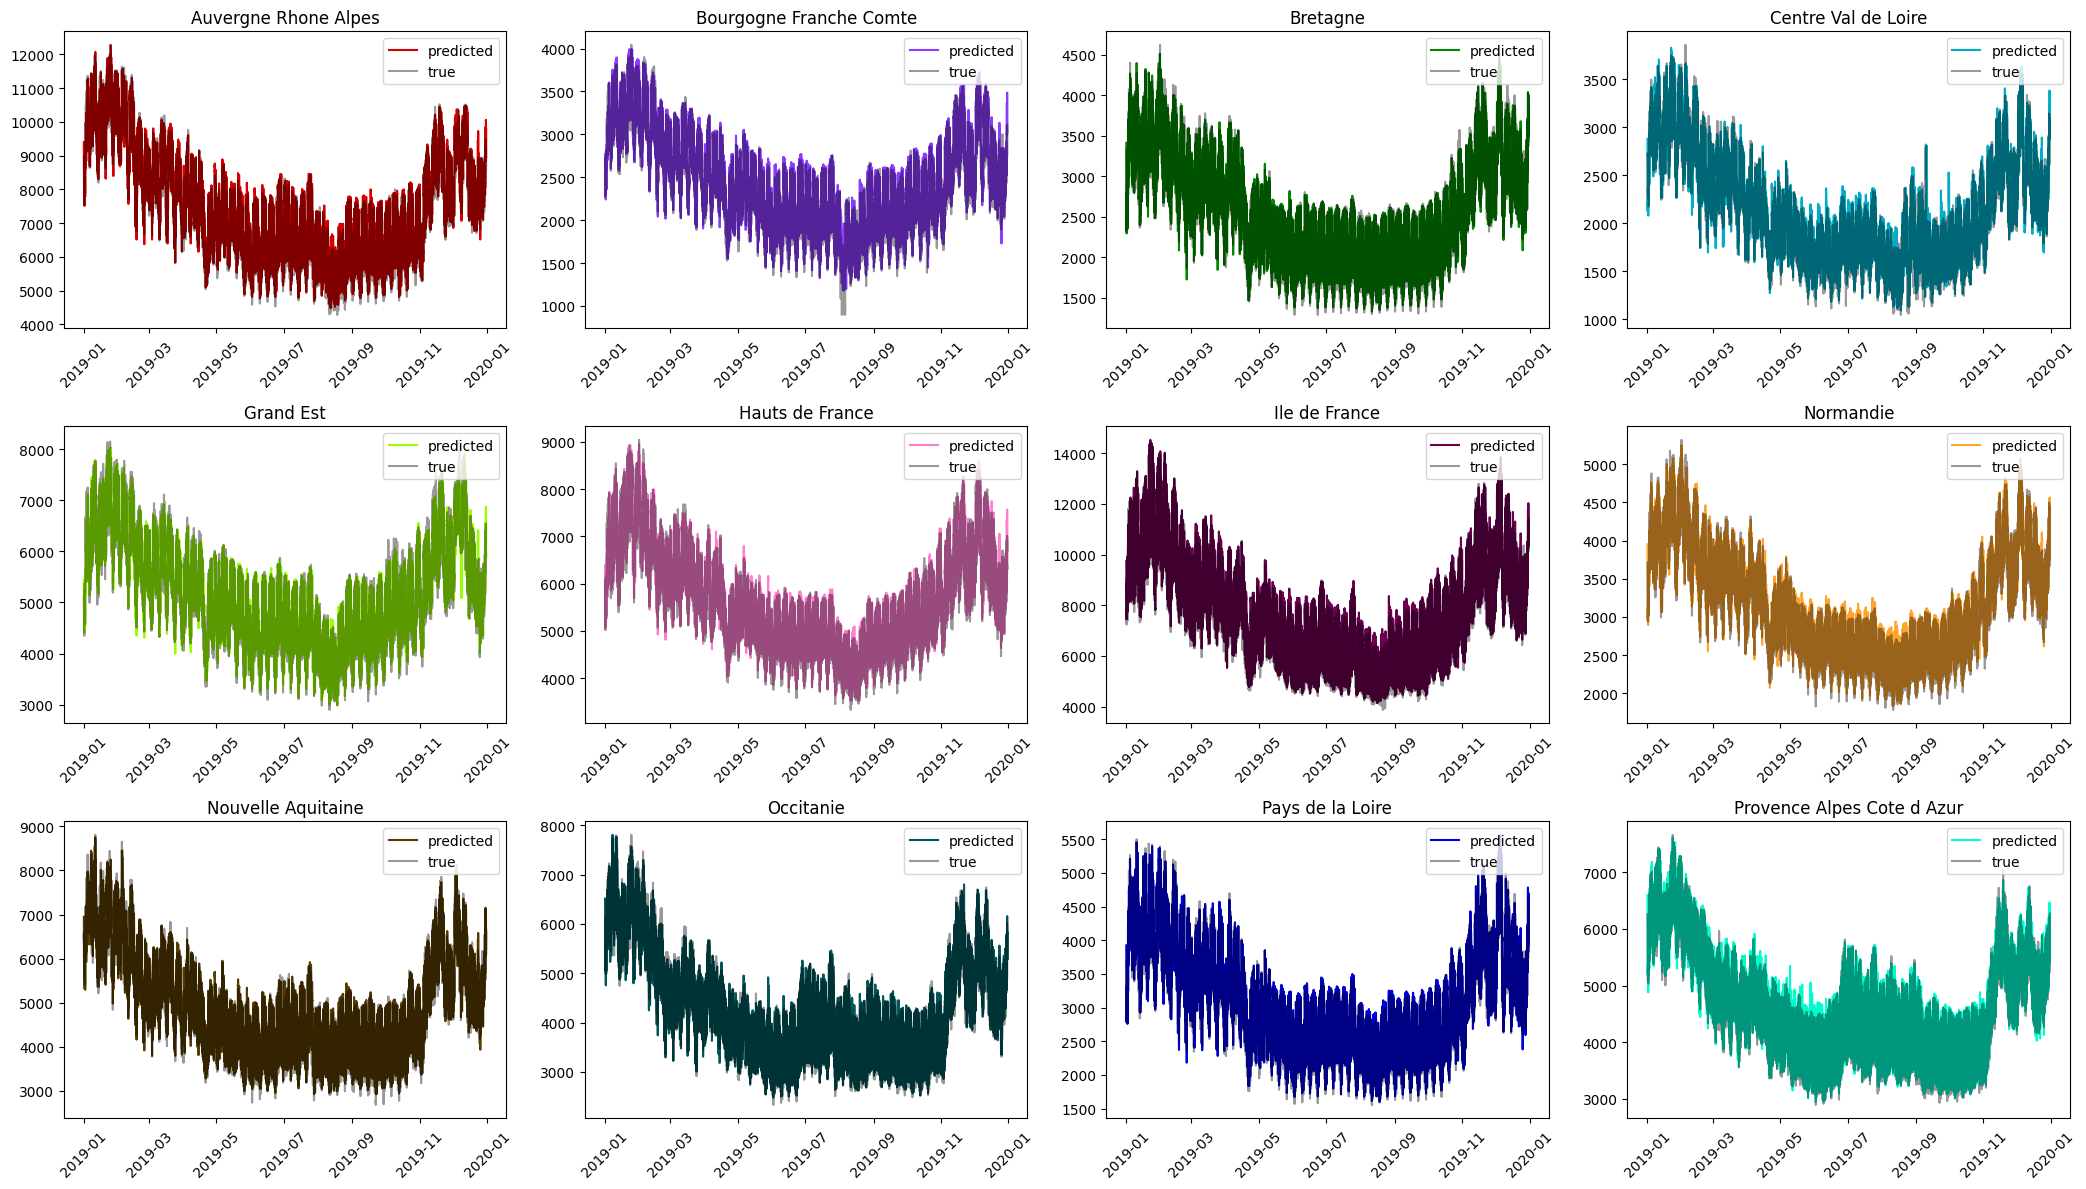

In [6]:
plot_nodes(true=target_test, pred=pred_model_test, graph_dataset=graph_dataset_test)

In [8]:
for i in range(pred_model_test.shape[0]-1):
    region = graph_dataset_train.nodes[i]
    preds = pred_model_test[i].cpu().detach()
    targets = target_test[i]
    print(f'RMSE {region} = {torch.round(RMSE(preds=preds, targets=targets))} MW')
    print(f'BIAS {region} = {torch.round(BIAS(preds=preds, targets=targets))} MW')
    print(f'MAPE {region} = {100*(MAPE(preds=preds, targets=targets))} %')

print(f'RMSE national = {torch.round(RMSE(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} MW')
print(f'BIAS national = {torch.round(BIAS(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} MW')
print(f'MAPE national = {100*(MAPE(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} %')

RMSE Auvergne_Rhone_Alpes = 216.0 MW
BIAS Auvergne_Rhone_Alpes = -95.0 MW
MAPE Auvergne_Rhone_Alpes = 2.3804352283477783 %
RMSE Bourgogne_Franche_Comte = 92.0 MW
BIAS Bourgogne_Franche_Comte = -37.0 MW
MAPE Bourgogne_Franche_Comte = 3.0429763793945312 %
RMSE Bretagne = 92.0 MW
BIAS Bretagne = -2.0 MW
MAPE Bretagne = 2.74263334274292 %
RMSE Centre_Val_de_Loire = 111.0 MW
BIAS Centre_Val_de_Loire = -29.0 MW
MAPE Centre_Val_de_Loire = 3.7840616703033447 %
RMSE Grand_Est = 178.0 MW
BIAS Grand_Est = -6.0 MW
MAPE Grand_Est = 2.4834322929382324 %
RMSE Hauts_de_France = 157.0 MW
BIAS Hauts_de_France = -45.0 MW
MAPE Hauts_de_France = 2.115920066833496 %
RMSE Ile_de_France = 279.0 MW
BIAS Ile_de_France = -132.0 MW
MAPE Ile_de_France = 2.8904929161071777 %
RMSE Normandie = 102.0 MW
BIAS Normandie = -38.0 MW
MAPE Normandie = 2.6957874298095703 %
RMSE Nouvelle_Aquitaine = 171.0 MW
BIAS Nouvelle_Aquitaine = -41.0 MW
MAPE Nouvelle_Aquitaine = 2.7562472820281982 %
RMSE Occitanie = 152.0 MW
BIAS Occita

# Optimizing a model

GNNs are a category of models that have a lot of hyperparameters which need to be tuned. The optimization module of the GraphToolbox uses Optuna, which is a well known optimization framework especially in the field of deep-learning.

In [ ]:
optim_base = {
    'num_layers': (1, 5),
    'hidden_channels': (32, 512),
    'lr': (1e-5, 1e-1),
}
optim_kwargs_conv = {
    'GCNConv': optim_base,
    'GraphSAGE': optim_base,
    'GATConv': optim_base | {'heads': (1, 5)}, 
    'GATv2Conv': optim_base | {'heads': (1, 5)}, 
    'TransformerConv': optim_base | {'heads': (1, 5)}, 
    'ChebConv': optim_base | {'K': (1, 10)},
    'TAGConv': optim_base | {'K': (1, 10)}, 
    'APPNP': optim_base | {'K': (1, 10), 'alpha': (.5, 1.)}
}
conv_class = APPNP
optim_kwargs = optim_kwargs_conv[conv_class.__name__]
optimizer = Optimizer(model=myGNN, 
                      dataset_train=graph_dataset_train,
                      dataset_val=graph_dataset_val,
                      conv_class=conv_class,
                      num_epochs=70,
                      optim_kwargs=optim_kwargs)
optimizer.optimize(n_trials=100)

2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,086 | INFO | Init logger.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.
2025-10-07 11:40:32,088 | INFO | Optimizer is initialized for model myGNN.


[I 2025-10-07 11:40:32,091] A new study created in memory with name: myGNN_hpo


2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.
2025-10-07 11:40:32,091 | INFO | Optimization began.


100%|██████████| 70/70 [00:01<00:00, 39.86it/s]
[I 2025-10-07 11:40:33,976] Trial 0 finished with value: inf and parameters: {'num_layers': 5, 'hidden_channels': 251, 'lr': 0.00029643239920079125, 'K': 8, 'alpha': 0.9126134577619844, 'batch_size': 16, 'adj_matrix': 'distsplines2'}. Best is trial 0 with value: inf.
100%|██████████| 70/70 [00:01<00:00, 44.52it/s]
[I 2025-10-07 11:40:35,670] Trial 1 finished with value: 0.0032210105564445257 and parameters: {'num_layers': 4, 'hidden_channels': 61, 'lr': 0.08803522360545606, 'K': 5, 'alpha': 0.8291426881165704, 'batch_size': 32, 'adj_matrix': 'gl3sr'}. Best is trial 1 with value: 0.0032210105564445257.
100%|██████████| 70/70 [00:01<00:00, 38.93it/s]
[I 2025-10-07 11:40:37,765] Trial 2 finished with value: 0.002395415445789695 and parameters: {'num_layers': 4, 'hidden_channels': 478, 'lr': 0.01689228177238424, 'K': 8, 'alpha': 0.9555963722880982, 'batch_size': 32, 'adj_matrix': 'distsplines'}. Best is trial 2 with value: 0.00239541544578969

2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
2025-10-07 11:41:32,077 | INFO | Optimization finished.
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  81
  Number of complete trials:  19
Best trial:
  Value:  0.002052093157544732
  Params: 
    num_layers: 4
    hidden_channels: 456
    lr: 0.003958328454811688
    K: 1
    alpha: 0.9386397747656074
    batch_size: 64
    adj_matrix: space
